In [5]:
# uplod data set dari kaggle
!pip install -q -U tensorflow_hub
!pip install -q -U tensorflow_datasets
!pip install -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"zidanpcd","key":"5469b7c59fcc52032a9d0593bfb4af49"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tedisetiady/leaf-rice-disease-indonesia


leaf-rice-disease-indonesia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler

In [6]:
import zipfile

path_to_zip_file = "/content/leaf-rice-disease-indonesia.zip"
directory_to_extract_to = "/content/leaf-rice-disease-indonesia"  # Ganti dengan path folder tujuan ekstraksi

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [7]:
import os
data_dir = '/content/leaf-rice-disease-indonesia'

In [8]:
print(os.listdir(data_dir))

['blast', 'blight', 'tungro']


In [9]:
from glob import glob
images = glob(os.path.join(data_dir, '*/*.jpg'))
tot_images = len(images)
print('Total images:', tot_images)

Total images: 240


In [10]:
tot_images = 3355
im_cnt = []
class_names = []
print('{:18s}'.format('Class'), end='')
print('Count')
print('-' * 24)
for folder in os.listdir(os.path.join(data_dir)):
    folder_num = len(os.listdir(os.path.join(data_dir, folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
    if (folder_num < tot_images):
        tot_images = folder_num
        folder_num = folder

num_classes = len(class_names)
print('Total number of classes: {}'.format(num_classes))

Class             Count
------------------------
blast                80
blight               80
tungro               80
Total number of classes: 3


In [11]:
data_transforms ={
    "train_transforms": transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])]),
   "valid_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])]),
    "test_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
}

In [12]:

# mmemisahkan dataset menjdai data train, data validasi , dan data test
train_data = 0.8
valid_data = 0.1
test_data = 0.1

# Load the dataset dengan image folder
train_data = datasets.ImageFolder(data_dir, transform=data_transforms["train_transforms"])
valid_data = datasets.ImageFolder(data_dir, transform=data_transforms["valid_transforms"])
test_data = datasets.ImageFolder(data_dir, transform=data_transforms["test_transforms"])

# proses pelatihan data
num_train = len(train_data)
indices = list(range(num_train))
# dipilih data acak untuk indeks
train_count = int(0.8*num_train)
valid_count = int(0.1*num_train)
test_count = num_train - train_count - valid_count
train_idx = indices[:train_count]
valid_idx = indices[train_count:train_count+valid_count]
test_idx = indices[train_count+valid_count:]

print(len(train_idx), len(valid_idx), len(test_idx))
print("Training", train_count, np.sum(len(train_idx)/num_train))
print("Validation", valid_count, np.sum(len(valid_idx)/num_train))
print("Test", test_count, np.sum(len(test_idx)/num_train))

192 24 24
Training 192 0.8
Validation 24 0.1
Test 24 0.1


In [13]:
# membuat loader baru untuk setiap pengambilan sampel yang berbeda
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [14]:
# Tentukan Dataloader menggunakan kumpulan data gambar. Dataloader digunakan untuk memuat data kita secara berkelompok
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 32, sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32, sampler = test_sampler)

In [15]:
classes=['LeafBlast', 'tugrou', 'blight']

In [16]:
# menampilkan gambar
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0)))

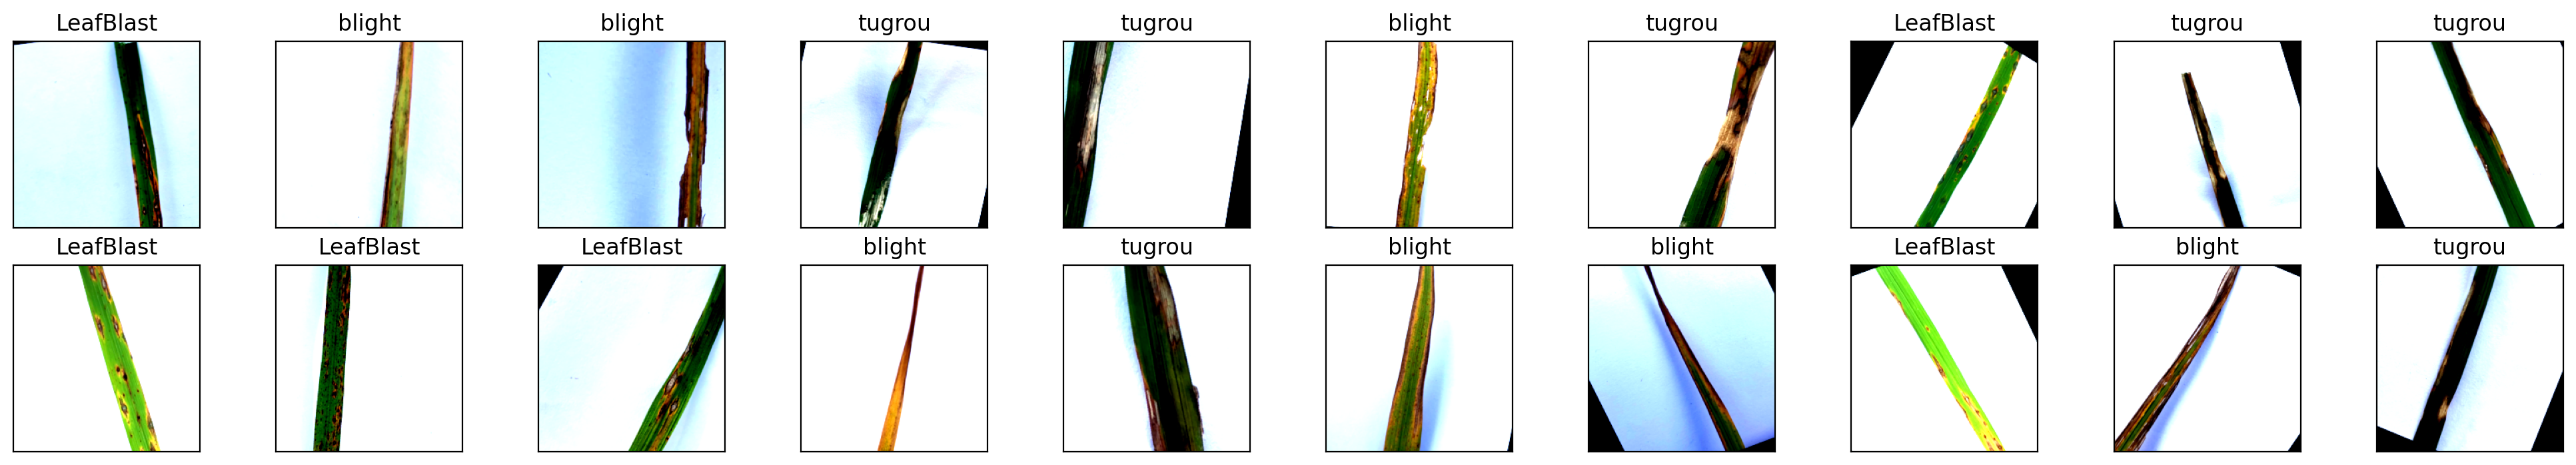

In [17]:
# menampilkan beberapa sample data
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

#Plot kumpulan gambar, bersama dengan label yang sesuai
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(str(labels[idx].item()))
    ax.set_title(classes[labels[idx]])

In [18]:
# Tentukan arsitektur model
# Muat model pra-pelatihan dari pustaka pytorch dan simpan di model_transfer
model_transfer = models.googlenet(pretrained=True)

# cek ketersediaan GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 87.2MB/s]


In [19]:
#print model untuk melihat semua layer
print(model_transfer)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [20]:
#membaca layer yang tersambung
print(model_transfer.fc.in_features)
print(model_transfer.fc.out_features)

1024
1000


In [21]:
for param in model_transfer.parameters():
    param.requires_grad=True

In [22]:
# Tentukan n_inputs untuk mengambil jumlah input yang sama dari model pra-pelatihan
n_inputs = model_transfer.fc.in_features

# menambah layer linear terrakhir (n_inputs -> 4 classes). dengan kasus 4 class
last_layer = nn.Linear(n_inputs, len(classes))

model_transfer.fc = last_layer

# pindah kan model ke GPU bila memungkinkan
if use_cuda:
    model_transfer = model_transfer.cuda()

#cek untuk melihat layer terakhir yang di produksi dengan jumlah output yang diharapkan
print(model_transfer.fc.out_features)

3


In [23]:
# Tentukan fungsi kerugian dan pengoptimal
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

In [24]:
# pelatihan model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''returns trained model'''
    # Inisialisasi pendeteksi untuk valid_loss_min
    valid_loss_min = np.inf

    for epoch in range(1, n_epochs+1):
        # pada proses looping training, ditentukan nilai loss
        # dan dibuat variabel untuk train dan validasi loss pada pelatihan dataset
        train_loss = 0.0
        valid_loss = 0.0

        # Model training data
        model.train()
        for batch_idx, (data,target) in enumerate(trainloader):
            # hubungkan GPU
            if use_cuda:
                data,target = data.cuda(), target.cuda()

            # Kemudian, di nol kan gradien dari semua variabel yang dioptimalkan
            optimizer.zero_grad()
            # Forward pass: hitung output yang diprediksi dengan meneruskan input ke model
            output = model(data)
            # Lakukan Cross Entropy Loss. Hitung kerugian batch.
            loss = criterion(output, target)
            # Backward pass: hitung gradien kerugian
            loss.backward()
            # Lakukan langkah optimalisasi (pembaruan parameter)
            optimizer.step()
            # Catat rata-rata kerugian pelatihan
            train_loss = train_loss + ((1/ (batch_idx + 1 ))*(loss.data-train_loss))

        # Model validation data
        model.eval()
        for batch_idx, (data,target) in enumerate(validloader):
            # pindahkan ke GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Update rata rata validasi loss
            # hitung output yang diprediksi dengan meneruskan input ke model
            output = model(data)
            # Hitung kerugian batch
            loss = criterion(output, target)
            # Perbarui ata-rata valid loss
            valid_loss = valid_loss + ((1/ (batch_idx +1)) * (loss.data - valid_loss))

        # cetak statistik pelatihan/validasi
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch,
            train_loss,
            valid_loss))

        # Simpan model jika validasi loss telah berkurang
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.5f} --> {:.5f}). Saving model ...'.format(
                  valid_loss_min,
                  valid_loss))
            torch.save(model.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss

    # Kembalikan model terlatih
    return model

# Tentukan transfer loader
loaders_transfer = {'train': trainloader,
                    'valid': validloader,
                    'test': testloader}



In [25]:
# proses looping iterasi (epoch)
model_transfer = train(15, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 1.11790 	Validation Loss: 1.18886
Validation loss decreased (inf --> 1.18886). Saving model ...
Epoch: 2 	Training Loss: 1.09472 	Validation Loss: 1.10722
Validation loss decreased (1.18886 --> 1.10722). Saving model ...
Epoch: 3 	Training Loss: 1.05850 	Validation Loss: 1.01429
Validation loss decreased (1.10722 --> 1.01429). Saving model ...
Epoch: 4 	Training Loss: 1.01242 	Validation Loss: 0.98882
Validation loss decreased (1.01429 --> 0.98882). Saving model ...
Epoch: 5 	Training Loss: 0.95984 	Validation Loss: 0.93684
Validation loss decreased (0.98882 --> 0.93684). Saving model ...
Epoch: 6 	Training Loss: 0.89262 	Validation Loss: 0.88853
Validation loss decreased (0.93684 --> 0.88853). Saving model ...
Epoch: 7 	Training Loss: 0.84428 	Validation Loss: 0.88461
Validation loss decreased (0.88853 --> 0.88461). Saving model ...
Epoch: 8 	Training Loss: 0.80138 	Validation Loss: 0.85537
Validation loss decreased (0.88461 --> 0.85537). Saving model ...
Epoc

In [26]:
# Muat model yang mendapatkan akurasi validasi terbaik
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [27]:
def test(loaders, model, criterion, use_cuda):

    # memantau kerugian dan akurasi pengujian
    test_loss = 0.
    correct = 0.
    total = 0.

    model_transfer.eval() # atur model ke mode evaluasi/pengujian
     # Mengulangi data uji
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # pindahkan ke GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: hitung output yang diprediksi dengan meneruskan input ke model
        output = model(data)
        # menghitung kerugian
        loss = criterion(output, target)
        # di perbarui test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # mengonversi probabilitas output ke kelas yang diprediksi
        pred = output.data.max(1, keepdim=True)[1]

        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# memanggil test fungtion
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.445352


Test Accuracy: 91% (22/24)


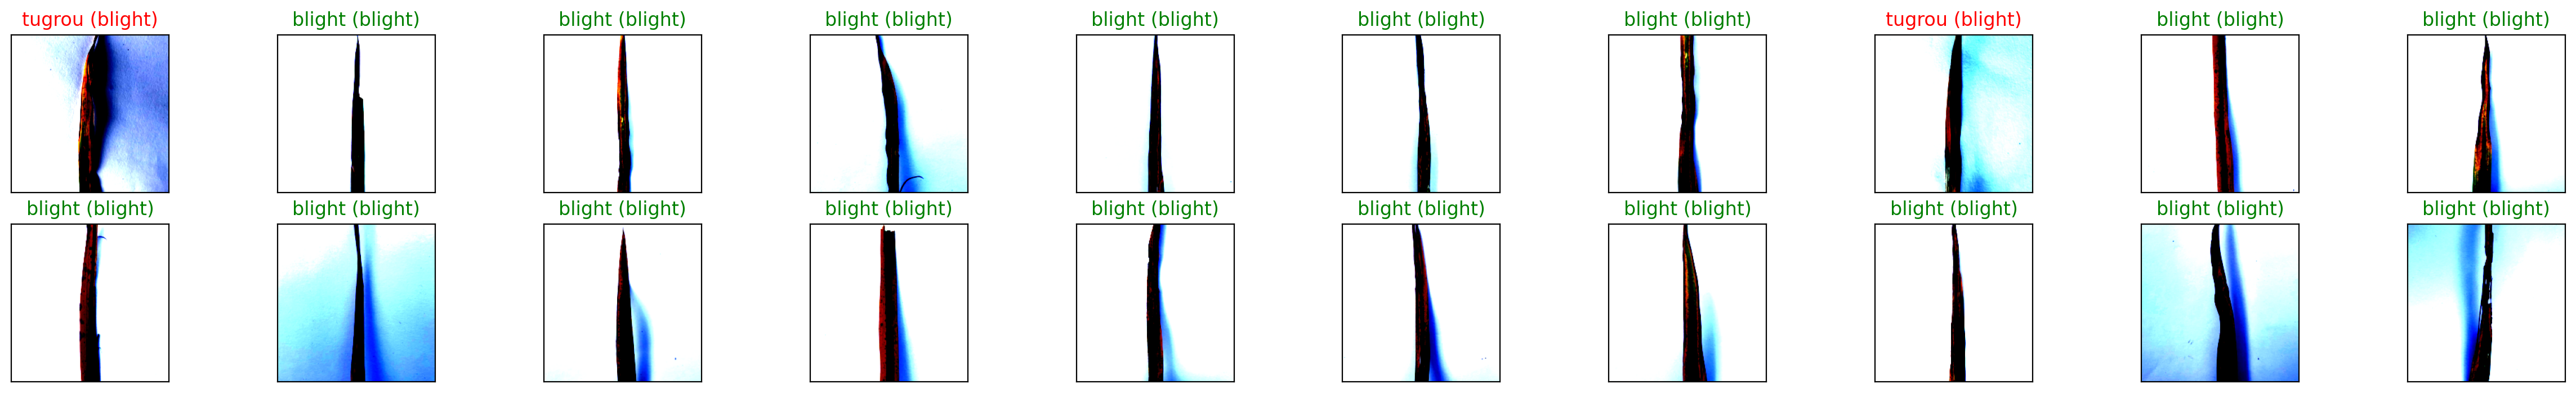

In [28]:
#memperoleh kumpulan test image
dataiter = iter(testloader)
images, labels = next(dataiter)
images.numpy

#input ke cuda
if use_cuda:
    images = images.cuda()

# diambil sample input
output= model_transfer(images)

# Ubah probabilitas keluaran menjadi kelas yang diprediksi deteksinya
_,preds_tensor = torch.max(output,1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

#Plot gambar , bersama dengan label yang diprediksi dengan keadaan hijau truee dan merah false
fig = plt.figure(figsize=(30,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images.cpu()[idx], (1,2,0)))
    ax.set_title("{} ({})".format(classes[preds[idx]],classes[labels[idx]]),
                color=("green" if preds[idx]==labels[idx].item() else "red"))